###### This code is deliberately ad-hoc. Instead of making things difficult for myself by writing libraries and modules, etc, I'm writing code as a I go and only afterwards if need be will refactor by modularizing everything. My focus is on scientific insight, not on maintaining a codebase and the extra effort is simply not worth the mental energy and time spent organizing everything. 

Additionally, letting loose with my coding practices is an important step in my development. I'm learning how to be a fearless experimenter by doing things against my nature. I've previously been really tight about modularizing and organizing my code and never writing ad-hoc scripts, instead crusting over my code with abstractions upon abstractions upon abstractions. No longer will this be! Sometimes you need to solve specific problems with specific code and rely on the power of the tools you work on and your own ability to craft new solutions with them at ease. 

So this explains the erratic nature of the code in my project. It's me fearlessly experimenting with science and math. 

I've come to appreciate how developments are made in science and math. Very intelligent and curious people perceive a void, a possibility, a need which leads them to asking questions as to how that void can be filled. They start rigorously testing solutions and looking at all the nuances of their solutions, refining and refining and testing and testing until they've arrived at something substancial and versatile. 

For instance, Principal Component Analysis is the subject of much literature - because it is so nuanced. There are so many factors that come into play and the technique didn't just appear. It needed to be developed, tested and refined and be critiqued and worked on by brilliant people. 

This leads me to my new goal to become a fearless experimenter. I need to get past that barrier of inexpertise and rigorously play around with the new mathematical, statistical, and scientific ideas I learn. That means playing around with PCA, with graph theory, etc. It means not being afraid to embrace complex new ideas by engaging with them at the deepest level possible. 

In [8]:
# Importing the transform code
import transform as tf
import dimensions_kit as dk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [9]:
transformed = []
pca = []
predicted = []

for worm, data in tf.wormData.iteritems():
    wd_pca, wd_transformed = tf.scikit_pca(data['deltaFOverF_deriv'], 3)  
    
    #Storing this for later use
    transformed.append(wd_transformed)
    pca.append(wd_pca)
    """
    Using our PC's we can increase the dimensionality of 
        our reduced data, from 3 to 107, thus getting a blurred
        dataset as predicted by PC's 1 and 2. It contains
        most of the information contained in the original
        data
    
    The operation is very simple - a transformation
        of 3 dimensional data to 107 dimensional data as the 
        dot product of the components and transformed data
    """ 
    predicted.append(np.dot(wd_pca.components_.T, wd_transformed.T))
    

# How principle components are correlated with eachother
# Correlated: <>0, Not: ~ 0
# Tells you waht is common among the principle components

In [10]:
len(predicted)

5

In [11]:
def plot_all_predicted(): 
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(3,2)
    for i in range(0,len(predicted)+1):
        # So we can layout our graphs
        # nicely in two dimensions
        # we need to map n <- R^1 to n'<-R^2 
        x,y = dk.transform((3,2), i) 
        ax = fig.add_subplot(gs[x,y])
        ax.set_title('Deriv-PCA Predicted ' + str(i))
        ax.pcolor(predicted[i-1])
    

In [12]:
"""
Here we will look at how the various datasets
compare with eachother. 

This enables us to answer the question of whether the same neurons have
similar PC strengths in all datasets. 
"""

# Here we plot the difference between two datasets
# The variance is fairly uniform except for at firing points
# where the pariance peaks
pred = predicted[0]
orig = tf.wormData[tf.wormData.keys()[0]]['deltaFOverF_deriv']
diff = orig.T-pred
diff.shape


# This transforms a 2d array into a set of points
pts = np.array([[x,y,diff[x,y]] for x in range(diff.shape[0]) for y in range(diff.shape[1]) ])

/Library/Python/2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


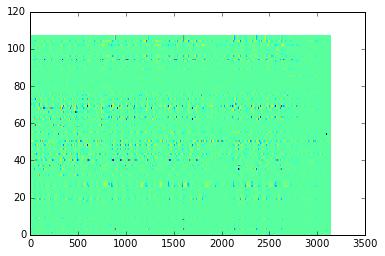

In [13]:
"""
This shows you the variance between the predicted data
and the original derivative data
"""

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(pts[:,0], pts[:,1],pts[:,2])


ax.pcolormesh(diff*1000)
fig.show()

This tells us that the variance is fairl uniform except for at critical points where
it scales by some large factor. 
This makes sense - the PC would scale large points to make them outliers. 

The next step suggested is: 

## Comparing Adjacent PCs Across Datasets. 

To do this, we need to line up all neurons shared in two datasets. We first need to ensure that doing this is worthwhile. 

In [14]:
# So that we can compare every worm with every worm, 
# we use combinations. (Binomial Coefficient, etc.)
from itertools import combinations
groupings  = [ i for i in combinations(range(5), r=2)]

# So we can access worms by index
keys = tf.wormData.keys()

# Tells us which neurons are present in the nth dataset
def get_neurons_present():
    neuron_names = [   
        { k[0]: idx 
        for idx, k in enumerate(tf.wormData[keys[i]]['NeuronIds'])
        if k != None and (len(k)>0) }
        # Forall worms
        for i in range(len(tf.wormData.keys())) ]
    return neuron_names

neurons_present = get_neurons_present()
neuron_names_present = [set(ns.keys()) for ns in neurons_present]

# I used this stackoverflow to get this way of finding
# the intersection of sets: http://bit.ly/1RiV6FE
all_shared_neurons = set.intersection(*neuron_names_present)

# similars[(i,j)] = neurons shared between ith and jth dataset

similars = {}
for i,j in groupings: 
    ns_i = neurons_present[i].keys()
    ns_j = neurons_present[j].keys()
    
    # This makes accessing things easier. 
    # You don't need to worry about the order. 
    similars[(i,j)] = similars[(j,i)] = set.intersection(set(ns_i), set(ns_j))

We've just set up a framework for comparing neuron sharing across our datasets. Now let's use it to compute some preliminary metrics. 

In [15]:

all_possible_shared = list(set.union(*neuron_names_present))

print "Total number neurons present in > 2 datasets: " + str(len(all_possible_shared))

# Percentage of comparable neurons of the whole dataset
print str(int(float(len(all_possible_shared))/302*100)) + "%"

Total number neurons present in > 2 datasets: 65
21%


Because there are so few shared neurons, I'm not sure what kind of insight we can get by comparing the principle components for each neuron.

Though after stepping back for a moment, I realized we can still get some insight if the shared neurons play important roles. Additionally, just comparing PCs for neurons across two datasets can provide some insight. So instead of comparing across all datasets, we can only compare across $x\geq2$ datasets. 

If we take this route, how many comparable neurons are there? **65**

What percentage of the whole dataset are they? **21**

What if we don't need to compare neurons shared across the entire dataset, but only across two readings?

# Neurons Shared by Paired Datasets

Now I'm going to do something very cool using matplotlib_venn. I'm going to visualize the intersection of our datasets. I'm sure we can get a better metric than just percentage neurons shared. 

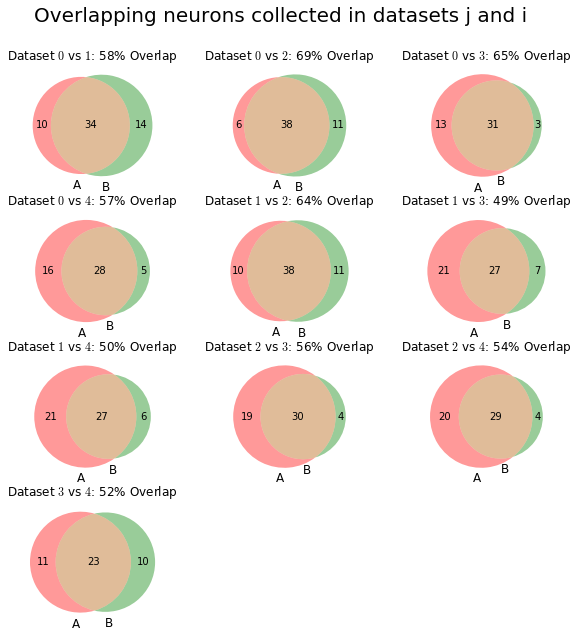

In [16]:
plt.clf()
%matplotlib inline
import numpy as np
from matplotlib_venn import *

import dimensions_kit as dk

dimensions = dk.dimensions(len(groupings))
f, axes = plt.subplots(*dimensions,figsize=(10,10))

f.suptitle('Overlapping neurons collected in datasets j and i', fontsize=20)
n=0
for k,i in groupings:
    
    names_k = neuron_names_present[k]
    names_i = neuron_names_present[i]
    
    x,y = dk.transform(dimensions,n)
    
    axis = axes[x][y]
    v = venn2(subsets=(names_k, names_i), ax=axis)
    
    intersection = float(len(names_k.intersection(names_i)))
    ttl = len(names_k)+len(names_i)-intersection
    ratio = int(intersection/ttl*100)
    
    axis.set_title('Dataset ${0}$ vs ${1}$: {2}% Overlap'.format(k,i,ratio ))
    plt.setp(axis.get_xticklabels(), visible=False)
    plt.setp(axis.get_yticklabels(), visible=False)

    n+=1
    
while n < dimensions[0]*dimensions[1]:
    x,y = dk.transform(dimensions,n)
    axes[x][y].axis('off')
    n+=1


## Starting to Compare The Two Datasets

Here is a list of ideas to consider. A set of very simple yet concrete questions we can go and answer. 

Originally I was unsure of how to look at complex datasets such as these. Once I had my revelation related to mathematics I recognized progress is driven by asking larger questions and breaking them down into smaller questions. Essentially, I'm looking for relationships - ways of relating dynamics to structure or structural patterns. Before I get into any serious graph theory or dynamical systems, or dynamical graph theory, I'm seeking inspiration from empirical data. Thus I start the process of developing a higher order theory by making observations on reality itself. 

My eventual goal is to start playing around with the pure mathematical ideas that arise from this experimental fishing expedition. I'll play around with the mathematical models I develop to build dynamical graphs with a goal in mind. 

First, I need to understand the empirical data. So here are some smaller questions I need to answer. 

- How many shared neurons play a significant role in a significant PC?
- Are these roles consistent across datasets?
- If any inconsistencies: why?
- Is classifying neurons consistent with their expected effect on global dynamics, i.e. muscle neurons, sensory neurons, etc. 
- Correlation between neuron degree and PC weight?

> I also feel compelled to mention my hazy revelation relating to NKS - production rules, and predicting dynamics. Well - simple things do create very complex, seemingly random behavior, but can some properties of this behavior be quantified - as a discrete dynamical system? Just a thought. 


Here are the components for all the datasets. 

In [36]:
components = [np.array(pc.components_) for pc in pca]
components

[array([[  4.48660674e-03,  -1.29013154e-02,   6.60232023e-04,
           2.72243921e-03,   7.47951285e-04,   3.53250084e-03,
           9.26743665e-04,  -3.21929689e-04,  -1.45631104e-03,
          -4.11744773e-02,   1.33655249e-03,   1.21351521e-03,
           9.79974793e-04,   3.31422652e-06,   1.89977062e-03,
           1.16149396e-03,   2.12101647e-03,  -2.50492751e-02,
          -9.12820806e-04,   7.31845412e-02,   2.55470245e-02,
           1.85209299e-02,   1.60218819e-03,  -4.62897032e-03,
           6.18190657e-03,   2.33835364e-04,  -2.52608561e-02,
          -4.64488025e-02,  -5.06929303e-02,   9.32819338e-03,
          -1.60319879e-04,   7.69628185e-04,  -5.54925336e-02,
           5.41660035e-03,   1.61204154e-03,  -1.62182704e-01,
          -2.82008205e-03,  -3.01552745e-01,   2.75747385e-03,
          -1.95857478e-03,   3.40854051e-01,   2.74489816e-01,
          -5.02287937e-02,   1.09765688e-02,  -7.79086288e-02,
           4.56272601e-03,   1.82114152e-01,   8.969903

In [37]:
all_shared_neurons

{u'AIBL',
 u'AIBR',
 u'ALA',
 u'AVAL',
 u'AVAR',
 u'AVBL',
 u'AVBR',
 u'AVER',
 u'RIBL',
 u'RID',
 u'RIML',
 u'RIMR',
 u'RIVL',
 u'RIVR',
 u'RMED',
 u'RMEL',
 u'RMER',
 u'SMDVR',
 u'VB01',
 u'VB02'}

Now we are going to use K-Means clustering     

## Beyond $[$vanilla$]$ PCA

- Dynamical graph theory
- Global neural network
- Markov chain/manifold signature
- Derivative of dynamics to remove instance theory related problems

**Papers**:

- http://www.alainconnes.org/docs/reconstructionshort.pdf
- *PRINCIPAL MANIFOLDS AND GRAPHS IN PRACTICE: FROM MOLECULAR BIOLOGY TO DYNAMICAL SYSTEMS*: http://arxiv.org/pdf/1001.1122.pdf
- *Discontinuous Dynamical Systems*: http://arxiv.org/pdf/0901.3583v1.pdf
- *Data Analysis Techniques for Nonlinear Dynamical Systems*: http://www.diee.unica.it/DRIEI/tesi/22_camplani.pdf
- *A Learning Rule for the Emergence of Stable Dynamics and Timing in Recurrent Networks*: https://www.neurobio.ucla.edu/~dbuono/PDFs/BuonoJNphy05.pdf
- *Dynamical systems and time series*: https://openaccess.leidenuniv.nl/bitstream/handle/1887/14735/muskulus-chapter-2.pdf?sequence=16
- *A view of Neural Networks as dynamical systems.*: http://arxiv.org/pdf/0901.2203v2.pdf
- *An Introduction to Dynamical Systems and Chaos*: http://www.ldeo.columbia.edu/~mspieg/Complexity/Problems.pdf
- *Metastable behavior in Markov processes with internal states*: http://arxiv.org/pdf/1304.6957v2.pdf

3/17/16 At the NeuroKernel hackathon I've gotten lots of *sensory input* which brought me to conceptualize new approaches and guiding principles to what I'm doing. 
t
I need to think about the whole picture and not get stuck with the little things that I'm doing–PCA, sticking to the Kato data, focusing solely on OpenWorm, etc. That is why speaking with people is so important–because it provides either confirmation or refutation of my own ideas but more importantly, exposure to new ones; super valuable insight. Collaboration is **sooo** key to research. 

**That is why this Neuro-Arch project is so important ** Research exponentiates when you can ask questions and query data really quickly. 

After speaking at length with Dave and revisiting graph theory, I've been thinking about how to connect what I have been doing now/recently with the **Kato** data. How will it bring published data under it's umbrella?

Two things just came to my mind, the first I'm recording for the sake of completeness and the second because it is relevant to the below: 
**Urgency Fallacy** - doing less important things to feign progress to yourself when it would serve you, your learning, and your research better if you spend more time delving into the meaty issues instead of the less important issues. 
**Empty Hypothesis Fallacy** when you invalidate all options without realizing that your hypothesis space was just too limited. 

1. I've realized that when originally I sought to describe network level dynamics I didn't quite perceive what that meant in concrete terms. Now I understand you must sometimes look at each individual component and from that build an understanding of the entire system. 
2. I'm going to see how static network properties map to dynamics and see if this holds across all 5 Kato datasets. This means comparing some static network properties 


Then, I can create hypotheses from my learnings here and attempt to validate them. 

One of the important things I learned at the conference from the researcher from Taiwan is that connectivity doesn't imply functionality. While his model was anatomically correct, it did not account for variation and specialization  It is really important to know the physiological mechanisms (that is what the experimentalists are for) which the theorists can then incorporate in their models either as pluginable parameters or ones central to the development of the model. 

3/23/16 First of all, I've made significant progress with OpenWorm. They are now discussing creating a new openworm project for spike train analysis. 

But getting back to the science, I've been wondering how best to compare these spike trains – which I'm hoping will lead me to some theories I can try to verify computationally, i.e. I'm now still in the exploration phase. I found [this](http://mathematical-neuroscience.springeropen.com/articles/10.1186/s13408-015-0030-9#CR29) paper and asked [this](http://cogsci.stackexchange.com/questions/13617/how-to-interpret-neuron-spiking-models-one-comes-across-in-literature) on binwise, probabalistic comparisions of neural spike trains beyond pairwise correlations. I'm going to spend more time digging through this research and reading up about the various methods Josh Merel told me about beyond vanilla PCA. 